In [1]:
import pdb, math
import matplotlib.pyplot as plt
import numpy as np
import torch
import pdb
plt.rcParams["figure.figsize"] = (12,12)

In [2]:
H = 300
W = 300

ORIGIN = torch.from_numpy(np.array([0,0,-5]))

EPSILON = 0.01
INNER_STEP = .01

class DetectorSquare():
    def __init__(self, origin, h=100, w=120, z=0):
        self.h, self.w = h, w
        self.r = float(self.w) / self.h
        self.x1, self.x2, self.y1, self.y2, self.z1, self.z2 = -1, 1, -1. / self.r + .25, 1. / self.r + .25, z, -z
        self.xes = np.linspace(self.x1, self.x2, self.w)
        self.yes = np.linspace(self.y1, self.y2, self.h)

# origin is at -5, getector is at 5 placing objects in the middle        
detector = DetectorSquare(ORIGIN, h=H, w=W, z=5)

In [3]:
#rays from origin to correcponsing point on the detector place
rays = np.stack((detector.xes[:,None].repeat(detector.h,axis=1), 
                 detector.yes[:,None].repeat(detector.w,axis=1).transpose(), 
                 torch.zeros((detector.w,detector.h))))
rays = torch.from_numpy(rays).float()

In [4]:
#unit vectors from origin to detector plane
vectors = rays - torch.from_numpy(ORIGIN.numpy()[:,None,None]).float()

In [5]:
#starting positions over every vector
current_points = ORIGIN.repeat(detector.w,1).view(detector.w,3).repeat(detector.h,1).view(detector.h,detector.w,3).permute(2,1,0).float()

In [6]:
#placeholders
energy_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float()
range_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float()

In [7]:
def sphereSDF_torch(points,_): 
    return torch.sqrt(((points+0.2).pow(2).float()).sum(axis=0)) - torch.tensor(0.5)

def norm(vectors): return torch.sqrt((vectors).pow(2).sum(0))

def torch_displance_point_along_vector(rays0, vectors, distances):
    return rays0 + vectors*distances

length = lambda x: (x**2).sum(axis=0)**0.5

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
def boxSDF_torch(points, angle):
    angle = rotation_matrix([1,1,1],angle)
    points = torch.einsum('iq,ijk->qjk',torch.from_numpy(angle).float(),current_points)
    points = points 
    distance = torch.abs(points)-torch.from_numpy(np.array([0.2,0.1,0.1]))[:,None,None].float()
    
    first = length(torch.where(distance>0,distance,torch.tensor(0.)))
    tmp1 = torch.where(distance[1]>distance[2],distance[1],distance[2])
    tmp2 = torch.where(distance[0]>tmp1, distance[0], tmp1)
    second = torch.where(tmp2>0,torch.tensor(0.),tmp2)
    return (first + second)



In [8]:
class Scene():
    def __init__(self,objects):
        self.objects = objects
    
    def trace(self,p):
        object_distances = [o.trace(p) for o in self.objects]
        return torch.stack(object_distances).min(dim=0)[0]

In [9]:
class Sphere():
    def __init__(self,position, radius):
        self.position = position
        self.radius = radius
    
    def trace(self,points):
        return torch.sqrt(((points+self.position).pow(2).float()).sum(axis=0)) - torch.tensor(self.radius)
    
class Box():
    def __init__(self, position, dimensions, angle):
        self.position = torch.from_numpy(np.array(position))[:,None,None]
        self.dimensions = dimensions
        self.angle = angle
    
    def trace(self,points):
        angle = rotation_matrix([1,1,1],self.angle)
        
        points = torch.einsum('iq,ijk->qjk',torch.from_numpy(angle).float(),points)
        points = points 
        distance = torch.abs(points+self.position).float()-torch.from_numpy(np.array(self.dimensions))[:,None,None].float()

        first = length(torch.where(distance>0,distance,torch.tensor(0.)))
        tmp1 = torch.where(distance[1]>distance[2],distance[1],distance[2])
        tmp2 = torch.where(distance[0]>tmp1, distance[0], tmp1)
        second = torch.where(tmp2>0,torch.tensor(0.),tmp2)
        
        return (first + second)

In [31]:
#starting positions over every vector
current_points = ORIGIN.repeat(detector.w,1).view(detector.w,3).repeat(detector.h,1).view(detector.h,detector.w,3).permute(2,1,0).float()
#placeholders
energy_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float()
range_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float()

INNER_STEP_TORCH = torch.tensor(INNER_STEP)
vector_normals = (vectors.float() / norm(vectors.float()))
ORIGIN_TORCH = ORIGIN.float()[:,None,None] 
TORCH_ZERO = torch.tensor(0.)
TORCH_ONE = torch.tensor(1.)

s = Sphere(torch.from_numpy(np.array([0,-0.5,-5]))[:,None,None],0.2)
b1 = Box([0,-0,0.0],[0.1,0.2,0.2],0.3)
b2 = Box([0.2,-0.8,0.0],[0.1,0.1,0.2],0.3)
b3 = Box([-0.2,0.2,0.3],[0.2,0.1,0.2],0.5)
b4 = Box([-0.4,0.5,0.0],[0.1,0.4,0.2],0.44)

scene = Scene([s,b1,b2,b3,b4])
# while True:
for i in range(50):
    min_distance = scene.trace(current_points) 
#     print(min_distance.min())
    min_distance = torch.where(min_distance>EPSILON, min_distance.float(), INNER_STEP_TORCH)
#     min_distance = torch.where(min_distance>100, min_distance.float(), torch.tensor(100))
    current_points = torch_displance_point_along_vector(ORIGIN_TORCH, vector_normals, range_map.float()+min_distance.float()) 

    range_map  += min_distance
    energy_map += torch.where(min_distance>EPSILON, TORCH_ZERO, TORCH_ONE)
    if min_distance.min()>10: break

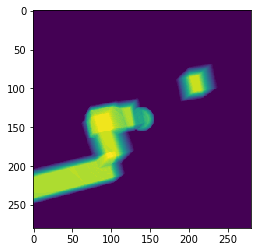

In [32]:
plt.imshow(energy_map[10:-10,10:-10])
plt.show()

In [30]:
TORCH_ZERO = torch.tensor(0.)
TORCH_ONE = torch.tensor(1.)
def timeme():
    #unit vectors from origin to detector plane
    vectors = rays - torch.from_numpy(ORIGIN.numpy()[:,None,None]).float()
    #starting positions over every vector
    current_points = ORIGIN.repeat(detector.w,1).view(detector.w,3).repeat(detector.h,1).view(detector.h,detector.w,3).permute(2,1,0).float()
    #placeholders
    energy_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float()
    range_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float()
    INNER_STEP_TORCH = torch.tensor(INNER_STEP)
    vector_normals = (vectors.float() / norm(vectors.float()))
    ORIGIN_TORCH = ORIGIN.float()[:,None,None] 
    while True:
        min_distance = sphereSDF_torch(current_points,_)
        min_distance = torch.where(min_distance>EPSILON, min_distance.float(), INNER_STEP_TORCH)
        current_points = torch.where(min_distance<10, torch_displance_point_along_vector(ORIGIN_TORCH, vector_normals, range_map.float()+min_distance.float()),current_points)
#         current_points = torch_displance_point_along_vector(ORIGIN_TORCH, vector_normals, range_map.float()+min_distance.float()) 

        range_map  += min_distance
        energy_map += torch.where(min_distance>EPSILON, TORCH_ZERO, TORCH_ONE)
        if min_distance.min()>10: break

In [135]:
%timeit timeme()

79.5 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
